<a href="https://colab.research.google.com/github/philqc/Deep-Value-Networks-Pytorch/blob/master/FCN_baseline_Img_Seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms.functional as TF
import numbers
import random
import os
import pickle
import time
import math
import copy
import pdb
from skimage import io

    100% |████████████████████████████████| 753.6MB 4.7MB/s 
fastai 1.0.50.post1 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.


For some reason, we are getting AttributeError: module 'PIL.Image' has no attribute 'register_extensions if we don't install pillow version 4.1.1

In [0]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

Load the dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# directory path to store results/plots/models
dir_path = 'drive/My Drive/projet_asp'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Auxiliary functions

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

class MyDataset(Dataset):

    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

    def __len__(self):
        return len(self.inputs)


def show_img(img, black_and_white=True):
    np_img = img.numpy()
    # put channel at the end for plt.imshow
    if np_img.ndim == 3:
        np_img = np.transpose(np_img, (1, 2, 0))

    #print('np_img.shape', np_img.shape)
    if black_and_white:
        plt.imshow(np_img, cmap='Greys_r')
        plt.show()
    else:
        plt.imshow(np_img)
        plt.show()


def save_img(img, path_to_save, black_and_white=True):
    np_img = img.numpy()
    np_img = np.transpose(np_img, (1, 2, 0))
    if black_and_white:
        plt.imsave(path_to_save + ".jpg", np_img, cmap='Greys_r')
    else:
        plt.imsave(path_to_save + ".jpg", np_img)


def save_grid_imgs(input_imgs, path_to_save, black_and_white=True):
    img = utils.make_grid(input_imgs, nrow=8)
    save_img(img, path_to_save, black_and_white)
    
def show_grid_imgs(input_imgs, black_and_white=True):
    img = utils.make_grid(input_imgs, nrow=8)  
    show_img(img, black_and_white)


def plot_results(results, iou):
    """
    Parameters:
    ----------
    results: dictionary with the train/valid loss
    and the f1 scores]
    iou: bool
      if true: print IOU, else print F1 Score
    """
    str_score = 'IOU' if iou else 'F1 Score'
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.set_title('Validation Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epochs')
    ax2.set_title('Validation ' + str_score)
    ax2.set_ylabel(str_score)
    ax2.set_xlabel('epochs')

    ax1.plot(results['loss_train'], label='loss_train')
    ax1.plot(results['loss_valid'], label='loss_valid')
    if iou:
      ax2.plot(results['IOU_valid'])
    else:
      ax2.plot(results['f1_valid'])
      
    ax1.legend()
    plt.show()

Deep Value Network

In [0]:
def cross_entropy2d(inputs, target, weight=None, size_average=False):
    """https://github.com/RohanDoshi2018/pytorch-fcn/blob/master/torchfcn/trainer.py"""
    # input: (n, c, h, w), target: (n, h, w)
    n, c, h, w = inputs.size()
    target = target.view(n, h, w)
    #print('n ={}; c = {}; h = {}; w ={}'.format(n, c, h, w))
    #print('inputs.size() =', inputs.size(), 'target.size() =', target.size())
    # log_p: (n, c, h, w)
    log_p = F.log_softmax(inputs, dim=1)
    # log_p: (n*h*w, c)
    log_p = log_p.permute(0, 2, 3, 1).contiguous()
    log_p = log_p[target.view(n, h, w, 1).repeat(1, 1, 1, c) >= 0]
    log_p = log_p.view(-1, c)
    # target: (n*h*w,)
    mask = target >= 0
    target = target[mask]
    loss = F.nll_loss(log_p, target.long(), weight=weight, reduction='sum')
    if size_average:
        loss /= mask.data.sum()
    return loss

def thirtysix_crop(img, size):
    """ Crop the given PIL Image 32x32 into 36 crops of 24x24
    Inspired from five_crop implementation in pytorch
    https://pytorch.org/docs/master/_modules/torchvision/transforms/functional.html
    """
    if isinstance(size, numbers.Number):
        size = (int(size), int(size))
    else:
        assert len(size) == 2, "Please provide only two dimensions (h, w) for size."
        
    w, h = img.size
    crop_h, crop_w = size
    if crop_w > w or crop_h > h:
        raise ValueError("Requested crop size {} is bigger than input size {}"
                         "".format(size, (h, w)))
    crops = []    
    for i in [0, 2, 3, 4, 5, 8]:
        for j in [0, 2, 3, 4, 5, 8]:
            c = img.crop((i, j, crop_w + i, crop_h + j))
            if c.size != size:
                raise ValueError("Crop size is {} but should be {}"
                                 "".format( c.size, size))
            crops.append(c)
               
    return crops
    
    
def average_over_crops(crops, device):
    N, n_crops, n_class, h, w = crops.shape
    pred = crops.permute(0, 1, 3, 4, 2).contiguous().view(-1, n_class).argmax(dim=1).view(N, n_crops, h, w)
        
    final = torch.zeros(N, 32, 32).to(device)
    size = torch.zeros(32, 32).to(device)
    for i, x in enumerate([0, 2, 3, 4, 5, 8]):
        for j, y in enumerate([0, 2, 3, 4, 5, 8]):
            k = i * 6 + j
            #pdb.set_trace()
            final[:, x: w + x, y:h + y] += pred[:, k].float()
            size[x: w + x, y:h + y] += 1
    
    final /= size
    final = final.view(N, 1, 32, 32)
    #pdb.set_trace()
    return final 

  
class FCNBaseLine(nn.Module):

    def __init__(self, non_linearity='relu', use_batch_norm=False):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, 1, padding=2)
        self.conv2 = nn.Conv2d(64, 128, 5, 2, padding=2)
        self.conv3 = nn.Conv2d(128, 128, 5, 2, padding=2)

        # Taken from https://openreview.net/forum?id=By40DoAqtX
        #self.deconv1 = nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1)
        #self.deconv2 = nn.ConvTranspose2d(1, 1, kernel_size=8, stride=4, padding=14)

        # Mine
        self.deconv1 = nn.ConvTranspose2d(128, 2, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(2, 2, kernel_size=4, stride=2, padding=1)

        self.bn1 = nn.BatchNorm2d(64) if use_batch_norm else None
        self.bn2 = nn.BatchNorm2d(128) if use_batch_norm else None
        self.bn3 = nn.BatchNorm2d(128) if use_batch_norm else None
        self.bn4 = nn.BatchNorm2d(2) if use_batch_norm else None

        non_linearity = non_linearity.lower()
        if non_linearity == 'softplus':
            self.non_linearity = nn.Softplus()
        elif non_linearity == 'relu':
            self.non_linearity = nn.ReLU()
        elif non_linearity == 'elu':
            self.non_linearity = nn.ELU()
        elif non_linearity == 'tanh':
            self.non_linearity = nn.Tanh()
        else:
            raise ValueError('Unknown activation Convnet:', non_linearity)
         
        self.use_batch_norm = use_batch_norm
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, z):
        #print('(0) z.shape=', z.shape)
        if self.use_batch_norm:
            z = self.non_linearity(self.bn1(self.conv1(z)))
            #print('(1) z.shape=', z.shape)
            z = self.non_linearity(self.bn2(self.conv2(z)))
            #print('(2) z.shape=', z.shape)
            z = self.non_linearity(self.bn3(self.conv3(z)))
            #print('(3) z.shape=', z.shape)
            z = self.non_linearity(self.bn4(self.deconv1(z)))
            #print('(4) z.shape=', z.shape)
            z = self.deconv2(z)
        else:
            z = self.non_linearity(self.conv1(z))
            z = self.non_linearity(self.conv2(z))
            z = self.non_linearity(self.conv3(z))
            z = self.non_linearity(self.deconv1(z))
            #z = self.dropout(z)
            z = self.deconv2(z)

        #print('(5) z.shape=', z.shape)
        return z  # size = (N, n_class, x.H/1, x.W/1)

      

class FullyConvNet:
    def __init__(self, train_loader, valid_loader, dir_path, use_cuda,
                 non_linearity='relu', learning_rate=1e-3, feature_dim=(24, 24), label_dim=(24, 24)):

        self.device = torch.device("cuda" if use_cuda else "cpu")
        self.feature_dim = feature_dim
        self.label_dim = label_dim

        # Using standard FCN
        self.model = FCNBaseLine(non_linearity, use_batch_norm=True).to(self.device)

        # Binary Cross entropy loss
        # Computes independent loss for each label in the vector
        # Our final loss is the sum over all our losses
        self.loss_fn = nn.BCEWithLogitsLoss(reduction='sum')

        # Hyperparameters from LDRSP paper
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3, 
                                          weight_decay=1e-4)

        self.n_class = 2       
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.n_train = len(train_loader.dataset)
        self.n_valid = len(valid_loader.dataset)
        print('Using a {} train {} validation split'.format(self.n_train, self.n_valid))
        self.batch_size = train_loader.batch_size
        self.batch_size_eval = valid_loader.batch_size
        
        # turn on/off
        self.training = False

    def get_oracle_value(self, pred_labels, gt_labels):
        """
        Compute the ground truth value, i.e. v*(y, y*)
        of some predicted labels, where v*(y, y*)
        is the relaxed version of the IOU (intersection
        over union) when training, and the discrete IOU
        when validating/testing
        """
        if pred_labels.shape != gt_labels.shape:
            raise ValueError('Invalid labels shape: gt = ', gt_labels.shape, 'pred = ', pred_labels.shape)

        if not self.training:
            # No relaxation, 0-1 only
            pred_labels = torch.where(pred_labels >= 0.5,
                                      torch.ones(1).to(self.device),
                                      torch.zeros(1).to(self.device))
            pred_labels = pred_labels.float()

        pred_labels = torch.flatten(pred_labels).reshape(pred_labels.size()[0], -1)
        gt_labels = torch.flatten(gt_labels).reshape(gt_labels.size()[0], -1)

        intersect = torch.min(pred_labels, gt_labels)
        union = torch.max(pred_labels, gt_labels)

        # for numerical stability
        epsilon = torch.full(union.size(), 10 ** -8).to(self.device)

        f1 = 2 * intersect / (intersect + torch.max(epsilon, union))
        # we want a (Batch_size x 1) tensor
        #iou = iou.view(-1, 1)
        #pdb.set_trace()
        return f1
      
    def get_iou_value(self, pred_labels, gt_labels):
        """
        Compute the ground truth value, i.e. v*(y, y*)
        of some predicted labels, where v*(y, y*)
        is the relaxed version of the IOU (intersection
        over union) when training, and the discrete IOU
        when validating/testing
        """
        if pred_labels.shape != gt_labels.shape:
            raise ValueError('Invalid labels shape: gt = ', gt_labels.shape, 'pred = ', pred_labels.shape)

        if not self.training:
            # No relaxation, 0-1 only
            pred_labels = torch.where(pred_labels >= 0.5,
                                      torch.ones(1).to(self.device),
                                      torch.zeros(1).to(self.device))
            pred_labels = pred_labels.float()

        pred_labels = torch.flatten(pred_labels).reshape(pred_labels.size()[0], -1)
        gt_labels = torch.flatten(gt_labels).reshape(gt_labels.size()[0], -1)

        intersect = torch.sum(torch.min(pred_labels, gt_labels), dim=1)
        union = torch.sum(torch.max(pred_labels, gt_labels), dim=1)

        # for numerical stability
        epsilon = torch.full(union.size(), 10 ** -8).to(self.device)
        
        iou = intersect / torch.max(epsilon, union)
        # we want a (Batch_size x 1) tensor
        iou = iou.view(-1, 1)
        #pdb.set_trace()
        return iou

    def train(self, ep):

        self.model.train()
        self.training = True

        time_start = time.time()
        t_loss, t_size = 0, 0
        
        for batch_idx, (raw_inputs, inputs, targets) in enumerate(self.train_loader):

            inputs, targets = inputs.to(self.device), targets.to(self.device)
            inputs, targets = inputs.float(), targets.float()
            
            t_size += len(inputs)

            self.model.zero_grad()

            output = self.model(inputs)
            
            loss = cross_entropy2d(output, targets)           
            t_loss += loss.item()

            loss.backward()
            self.optimizer.step()
            
            # Get prediction accross (argmax accross n_class depth)
            N, c, h, w = output.shape
            pred = output.permute(0, 2, 3, 1).contiguous().view(-1, c).argmax(dim=1).view(N, 1, h, w)
                        
            if batch_idx % 2 == 0:
                print('\rTraining Epoch {} [{} / {} ({:.0f}%)]: Time per epoch: {:.2f}s; '
                      'Avg_Loss = {:.5f}; IOU_batch = {:.2f}%'
                      ''.format(ep, t_size, self.n_train, 100 * t_size / self.n_train,
                               (self.n_train / t_size) * (time.time() - time_start), t_loss / t_size,
                               100 * self.get_iou_value(pred.float(), targets).mean()),
                      end='')
        
        if ep % 50 == 0:
            print('\nTRAIN ')
            img = raw_inputs.detach().cpu()
            show_grid_imgs(img)
               
            mask = pred.detach().cpu()
            # Put mask to float otherwise only outputs black images !!
            show_grid_imgs(mask.float())   
            print('---------------------------------------')
            
        t_loss /= t_size
        self.training = False
        print('')
        return t_loss

    def valid(self, loader, test_set=False, ep=0):

        self.model.eval()
        self.training = False

        loss, t_size = 0, 0
        mean_iou = []
        
        with torch.no_grad():
            for (raw_inputs, inputs, targets) in loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                inputs, targets = inputs.float(), targets.float()
            
                t_size += len(inputs)
                
                # For valid/test: inputs is a 5d tensor
                bs, ncrops, channels, h, w = inputs.size()
                
                output = self.model(inputs.view(-1, channels, h, w)) # fuse batch size and ncrops
                # go back to normal shape
                output = output.view(bs, ncrops, self.n_class, h, w)
                
                pred = average_over_crops(output, self.device)
                #output_avg = output.view(bs, ncrops, -1).mean(1) # avg over crops
                
                # go back to normal shape
                #output_avg = output_avg.view(bs, -1, h, w)
                
                #loss += cross_entropy2d(output_avg, targets)
                
                # Get prediction accross (argmax accross n_class depth)
                #N, n_class, h, w = output_avg.shape
                #pred = output_avg.permute(0, 2, 3, 1).contiguous().view(-1, n_class).argmax(dim=1).view(N, 1, h, w)
                
                mean_iou.append(self.get_iou_value(pred.float(), targets).mean()) 
                
        if ep % 50 == 0:
            img = raw_inputs.detach().cpu()
            show_grid_imgs(img) 
            mask = pred.detach().cpu()
            mask = mask >= 0.5
            # Put mask to float otherwise only outputs black images !!
            show_grid_imgs(mask.float())        
        
        mean_iou = torch.stack(mean_iou)
        mean_iou = torch.mean(mean_iou)
        mean_iou = mean_iou.cpu().numpy()
        loss /= t_size

        str_first = 'Test set' if test_set else 'Validation set'
        print('{}: IOU = {:.2f}%'
              ''.format(str_first, 100 * mean_iou))

        return loss, mean_iou


Functions to run epoch and also to run hyperparameter search

In [0]:
def run_fcn_model(train_loader, valid_loader, dir_path, use_cuda, n_epochs):

    FCN = FullyConvNet(train_loader, valid_loader, dir_path, use_cuda)

    results = {'name': 'FCN_Whorse', 'loss_train': [],
               'loss_valid': [], 'IOU_valid': [], 'batch_size': train_loader.batch_size,
               'batch_size_eval': valid_loader.batch_size}

    results_path = dir_path + '/results/'
    if not os.path.isdir(results_path):
        os.makedirs(results_path)

    # Increment a counter so that previous results with the same args will not
    # be overwritten. Comment out the next four lines if you only want to keep
    # the most recent results.
    i = 0
    while os.path.exists(results_path + str(i) + '.pkl'):
        i += 1
    results_path = results_path + str(i)

    for epoch in range(n_epochs):
        loss_train = FCN.train(epoch)
        loss_valid, iou_valid = FCN.valid(FCN.valid_loader, ep=epoch)
        results['loss_train'].append(loss_train)
        results['loss_valid'].append(loss_valid)
        results['IOU_valid'].append(iou_valid)

        with open(results_path + '.pkl', 'wb') as fout:
            pickle.dump(results, fout)
        

Load dataset and choose to use cpu or gpu

In [0]:
# build the dataset, generate the "training tuple"
class WeizmannHorseDataset(Dataset):
    """ Weizmann Horse Dataset """
    
    def __init__(self, img_dir, mask_dir, subset='train', transform=None,
                 random_mirroring=True):
        """
        Args:
            img_dir(string): Path to the image file (training image)
            mask_dir(string): Path to the mask file (segmentation result)
            subset(string): 'train' or 'valid' or 'test'
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_dir = img_dir
        self.mask_dir = mask_dir

        all_img_names = os.listdir(img_dir)
        all_mask_names = os.listdir(mask_dir)

        self.img_names = []
        self.mask_names = []
        for i, name in enumerate(all_img_names):
            img_number = ''.join([n for n in name if n.isdigit()])
            if int(img_number) >= 200:
                if subset == 'test':
                    self.img_names.append(name)
                    self.mask_names.append(all_mask_names[i])
            elif 180 <= int(img_number) < 200:
                if subset == 'valid':
                    self.img_names.append(name)
                    self.mask_names.append(all_mask_names[i])
            elif subset == 'train' and int(img_number) < 180:
                self.img_names.append(name)
                self.mask_names.append(all_mask_names[i])
        
        assert len(self.mask_names) == len(self.img_names)
        
        self.is_test = True if subset == 'valid' or subset == 'test' else False
        
        self.transform = transforms.Compose([transforms.ToPILImage(),
                                             transforms.Resize(size=(32, 32))])
        self.random_mirroring = random_mirroring
        self.normalize = None
        self.to_tensor = transforms.ToTensor()
        
        self.transform_test = transforms.Compose([transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                                  transforms.Lambda(lambda crops: torch.stack([self.normalize(crop) for crop in crops]))])
        
    def __len__(self):
        return len(self.img_names)
        
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_names[idx])
        mask_name = os.path.join(self.mask_dir, self.mask_names[idx])
        
        image = io.imread(img_name)
        mask = io.imread(mask_name)
               
        if self.transform:
                      
            image = self.transform(image)
            
            # create a channel for mask so as to transform
            mask = self.transform(np.expand_dims(mask, axis=2))
            
            if self.is_test:
                input_img = image
                # Use 36 crops averaging for valid/test
                image = thirtysix_crop(image, 24)
                image = self.transform_test(image)
            else:
                # Random crop
                i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(24, 24))
                image = TF.crop(image, i, j, h, w)                
                mask = TF.crop(mask, i, j, h, w)
                
                # Random Horizontal flipping
                if self.random_mirroring and random.random() > 0.50:
                    image = TF.hflip(image)
                    mask = TF.hflip(mask)
                
                input_img = image
                image = self.to_tensor(image)
                image = self.normalize(image)
            
            input_img = self.to_tensor(input_img)      
            mask = self.to_tensor(mask)
            
            # put mask to 0-1 again
            mask = mask >= 0.5
        
        return input_img, image, mask

    def compute_mean_and_stddev(self):
        n_images = len(self.img_names)
        masks, images = [], []

        # ToTensor transforms the images/masks in range [0, 1]
        transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize(size=(32, 32)),
                                        transforms.ToTensor()])

        for i in range(n_images):
            mask_name = os.path.join(self.mask_dir, self.mask_names[i])
            img_name = os.path.join(self.img_dir, self.img_names[i])
            mask = io.imread(mask_name)
            image = io.imread(img_name)

            image = transform(image)
            # create a channel for mask so as to transform
            mask = transform(np.expand_dims(mask, axis=2))

            masks.append(mask)
            images.append(image)

        # after torch.stack, we should have n_images x 1 x 32 x 32 for mask
        # and have n_images x 3 x 32 x 32 for images
        images, masks = torch.stack(images), torch.stack(masks)

        # compute mean and std_dev of images
        # put the images in n_images x 3 x (32x32) shape
        images = images.view(images.size(0), images.size(1), -1)
        mean_imgs = images.mean(2).sum(0) / n_images
        std_imgs = images.std(2).sum(0) / n_images
        ############################################

        # Find mean_mask for visualization purposes
        height, width = masks.shape[2], masks.shape[3]
        # flatten
        masks = masks.view(n_images, 1, -1)
        mean_mask = torch.mean(masks, dim=0)
        # go back to 32 x 32 view
        mean_mask = mean_mask.view(1, 1, height, width)

        print_mask = False
        if print_mask:
            img_to_show = mean_mask.squeeze(0)
            img_to_show = img_to_show.squeeze(0)
            show_img(img_to_show, black_and_white=True)

        return mean_imgs, std_imgs, mean_mask

# Use GPU if it is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
    
image_dir = dir_path + '/images'
mask_dir = dir_path + '/masks'

# Use Dataset to resize and convert to Tensor
train_set = WeizmannHorseDataset(image_dir, mask_dir, subset='train',
                                 transform=None, random_mirroring=True)

valid_set = WeizmannHorseDataset(image_dir, mask_dir, subset='valid',
                                 transform=None, random_mirroring=True)

batch_size = 20
batch_size_eval = 10

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    pin_memory=use_cuda
)

valid_loader = DataLoader(
    valid_set,
    batch_size=batch_size_eval,
    pin_memory=use_cuda
)

mean_imgs, std_imgs, mean_mask = train_set.compute_mean_and_stddev()
print('mean_imgs =', mean_imgs, 'std_dev_imgs =', std_imgs)

train_set.normalize = transforms.Normalize(mean_imgs, std_imgs)
valid_set.normalize = transforms.Normalize(mean_imgs, std_imgs)

mean_imgs = tensor([0.6131, 0.5283, 0.4726]) std_dev_imgs = tensor([0.2131, 0.2110, 0.2025])


In [0]:
Run the model

Using a 2 train 20 validation split
Training Epoch 0 [2 / 2 (100%)]: Time per epoch: 0.03s; Avg_Loss = 386.11588; IOU_batch = 5.25%
TRAIN 


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)


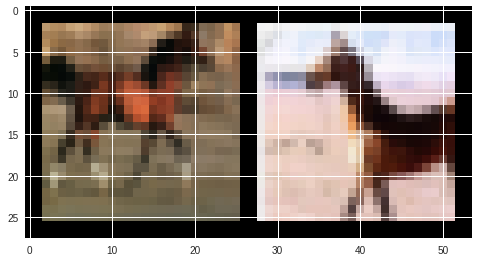

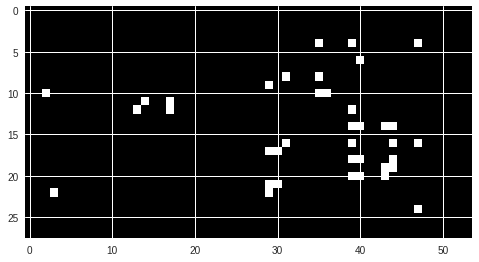

---------------------------------------



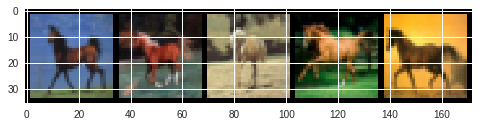

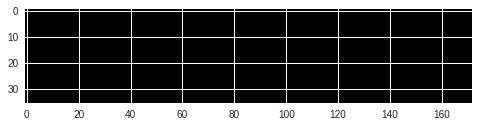

Validation set: IOU = 0.00%
Training Epoch 1 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 384.04416; IOU_batch = 0.91%
Validation set: IOU = 0.00%
Training Epoch 2 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 379.92825; IOU_batch = 1.11%
Validation set: IOU = 0.00%
Training Epoch 3 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 382.11346; IOU_batch = 1.72%
Validation set: IOU = 0.00%
Training Epoch 4 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 386.22791; IOU_batch = 1.00%
Validation set: IOU = 0.00%
Training Epoch 5 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 389.21408; IOU_batch = 1.06%
Validation set: IOU = 0.00%
Training Epoch 6 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 384.39108; IOU_batch = 1.40%
Validation set: IOU = 0.00%
Training Epoch 7 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 386.39932; IOU_batch = 0.45%
Validation set: IOU = 0.00%
Training Epoch 8 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 370.94119; IOU_batch = 0.74%
Validati

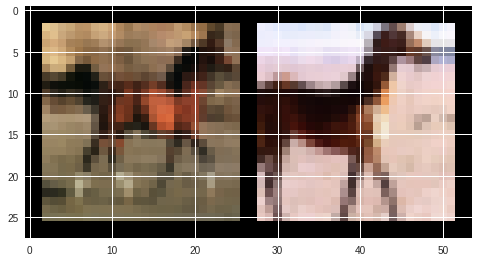

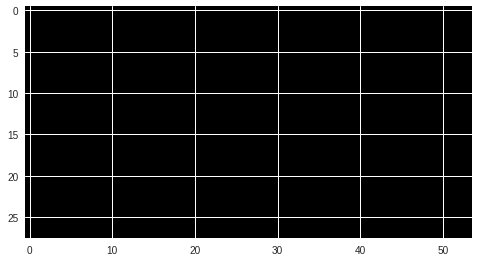

---------------------------------------



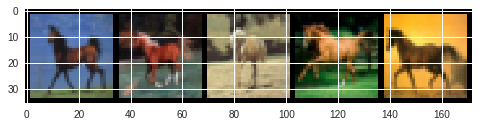

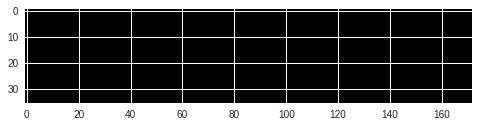

Validation set: IOU = 0.00%
Training Epoch 51 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 332.86279; IOU_batch = 0.00%
Validation set: IOU = 0.00%
Training Epoch 52 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 362.65796; IOU_batch = 0.00%
Validation set: IOU = 0.00%
Training Epoch 53 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 349.42172; IOU_batch = 0.00%
Validation set: IOU = 0.00%
Training Epoch 54 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 361.77127; IOU_batch = 0.00%
Validation set: IOU = 0.00%
Training Epoch 55 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 346.70987; IOU_batch = 0.00%
Validation set: IOU = 0.00%
Training Epoch 56 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 340.19946; IOU_batch = 0.00%
Validation set: IOU = 0.00%
Training Epoch 57 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 342.67599; IOU_batch = 0.00%
Validation set: IOU = 0.00%
Training Epoch 58 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 329.15399; IOU_batch = 0.00%


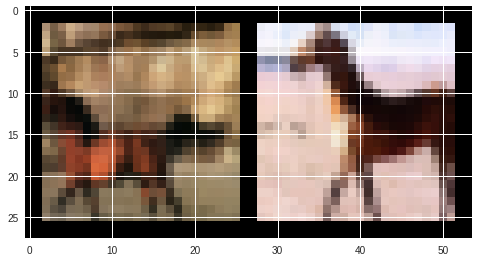

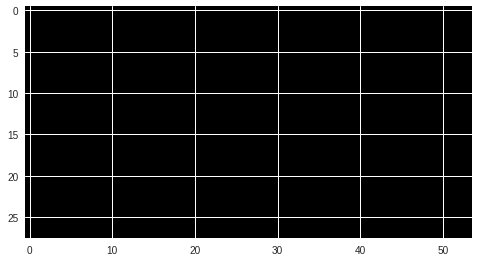

---------------------------------------



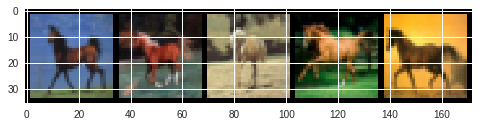

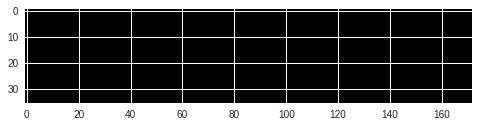

Validation set: IOU = 0.00%
Training Epoch 101 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 303.95306; IOU_batch = 0.00%
Validation set: IOU = 0.00%
Training Epoch 102 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 299.11249; IOU_batch = 0.00%
Validation set: IOU = 0.00%
Training Epoch 103 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 310.21536; IOU_batch = 0.00%
Validation set: IOU = 0.00%
Training Epoch 104 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 294.89081; IOU_batch = 0.00%
Validation set: IOU = 0.00%
Training Epoch 105 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 287.46854; IOU_batch = 0.00%
Validation set: IOU = 0.00%
Training Epoch 106 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 313.82855; IOU_batch = 0.00%
Validation set: IOU = 0.00%
Training Epoch 107 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 299.38205; IOU_batch = 0.00%
Validation set: IOU = 0.00%
Training Epoch 108 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 288.65366; IOU_batch 

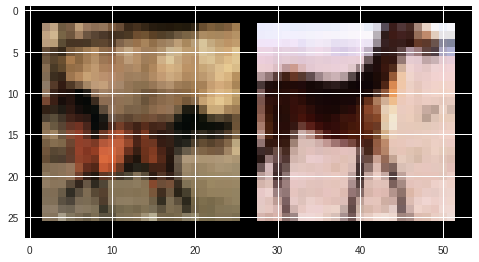

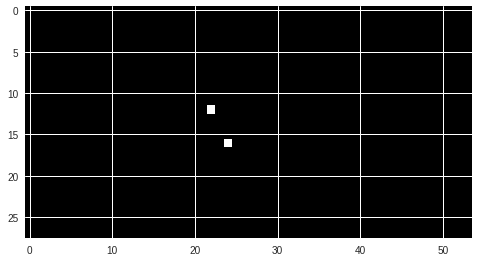

---------------------------------------



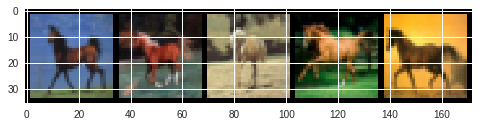

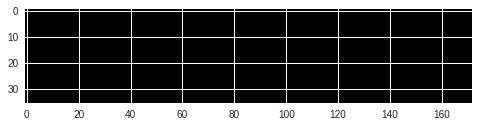

Validation set: IOU = 0.00%
Training Epoch 151 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 265.86874; IOU_batch = 0.59%
Validation set: IOU = 6.74%
Training Epoch 152 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 260.25681; IOU_batch = 60.83%
Validation set: IOU = 6.94%
Training Epoch 153 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 282.69193; IOU_batch = 48.80%
Validation set: IOU = 7.58%
Training Epoch 154 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 258.87775; IOU_batch = 58.85%
Validation set: IOU = 7.89%
Training Epoch 155 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 260.55731; IOU_batch = 61.56%
Validation set: IOU = 8.51%
Training Epoch 156 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 281.71988; IOU_batch = 52.15%
Validation set: IOU = 9.06%
Training Epoch 157 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 261.98242; IOU_batch = 64.79%
Validation set: IOU = 9.02%
Training Epoch 158 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 271.38742; IOU_

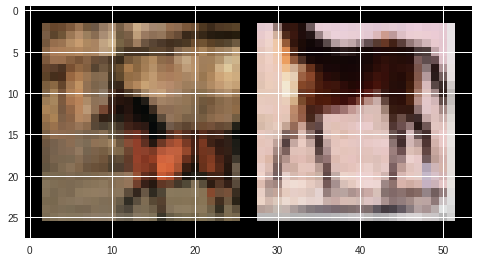

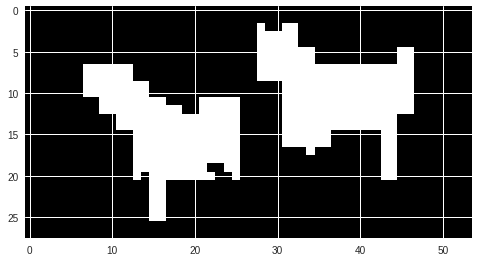

---------------------------------------



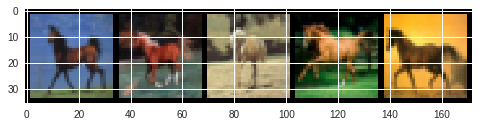

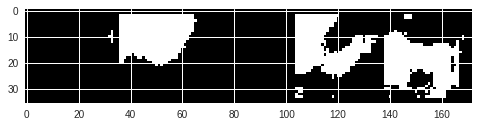

Validation set: IOU = 13.09%
Training Epoch 201 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 248.39684; IOU_batch = 69.37%
Validation set: IOU = 12.34%
Training Epoch 202 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 236.22859; IOU_batch = 73.49%
Validation set: IOU = 11.55%
Training Epoch 203 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 249.16939; IOU_batch = 71.29%
Validation set: IOU = 10.73%
Training Epoch 204 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 220.85052; IOU_batch = 77.17%
Validation set: IOU = 10.87%
Training Epoch 205 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 222.06473; IOU_batch = 78.71%
Validation set: IOU = 10.82%
Training Epoch 206 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 239.50034; IOU_batch = 78.29%
Validation set: IOU = 9.79%
Training Epoch 207 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 216.43330; IOU_batch = 79.48%
Validation set: IOU = 9.30%
Training Epoch 208 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 234.1499

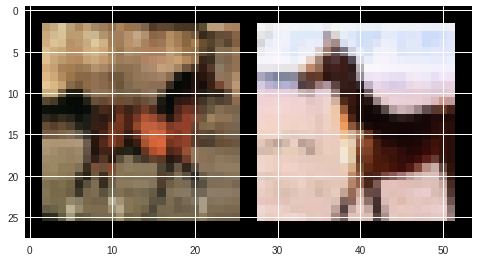

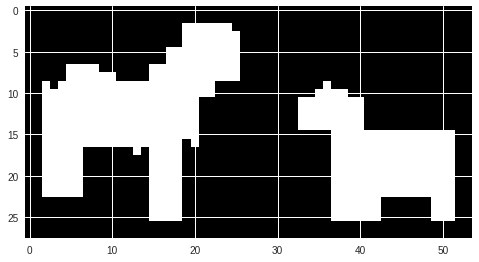

---------------------------------------



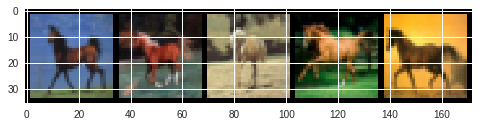

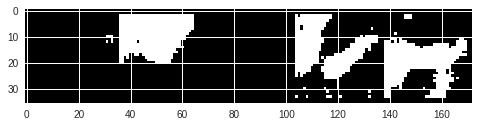

Validation set: IOU = 10.89%
Training Epoch 251 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 198.41644; IOU_batch = 77.25%
Validation set: IOU = 8.66%
Training Epoch 252 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 220.75346; IOU_batch = 76.27%
Validation set: IOU = 7.59%
Training Epoch 253 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 214.44476; IOU_batch = 77.58%
Validation set: IOU = 6.98%
Training Epoch 254 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 225.43483; IOU_batch = 76.86%
Validation set: IOU = 7.73%
Training Epoch 255 [2 / 2 (100%)]: Time per epoch: 0.03s; Avg_Loss = 199.90094; IOU_batch = 77.50%
Validation set: IOU = 8.62%
Training Epoch 256 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 187.21124; IOU_batch = 80.67%
Validation set: IOU = 10.20%
Training Epoch 257 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 203.50616; IOU_batch = 80.69%
Validation set: IOU = 12.67%
Training Epoch 258 [2 / 2 (100%)]: Time per epoch: 0.03s; Avg_Loss = 207.28069; 

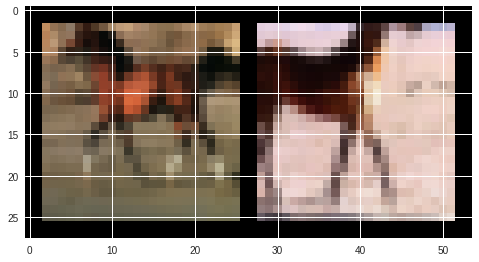

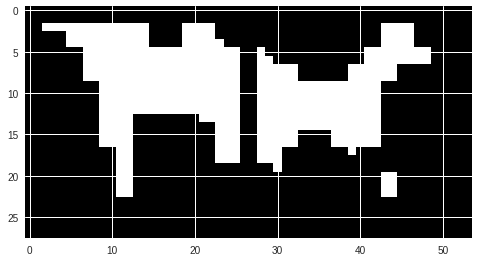

---------------------------------------



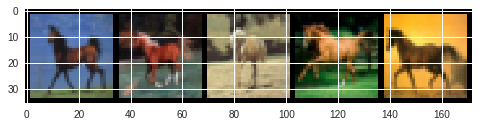

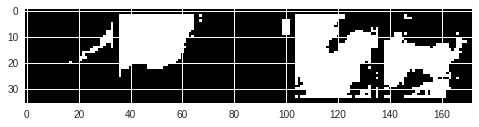

Validation set: IOU = 19.52%
Training Epoch 301 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 194.33360; IOU_batch = 80.88%
Validation set: IOU = 19.26%
Training Epoch 302 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 184.05154; IOU_batch = 83.70%
Validation set: IOU = 18.92%
Training Epoch 303 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 210.48917; IOU_batch = 78.16%
Validation set: IOU = 18.31%
Training Epoch 304 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 183.68166; IOU_batch = 82.11%
Validation set: IOU = 17.53%
Training Epoch 305 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 170.79805; IOU_batch = 84.60%
Validation set: IOU = 17.40%
Training Epoch 306 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 193.42300; IOU_batch = 82.16%
Validation set: IOU = 17.45%
Training Epoch 307 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 180.32907; IOU_batch = 80.66%
Validation set: IOU = 17.01%
Training Epoch 308 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 199.82

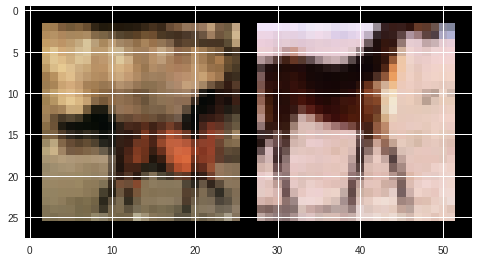

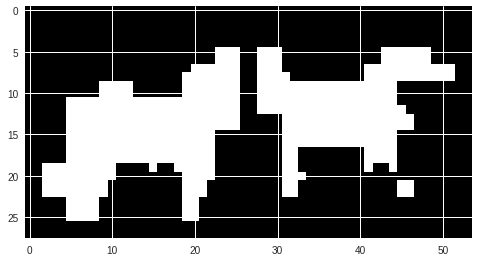

---------------------------------------



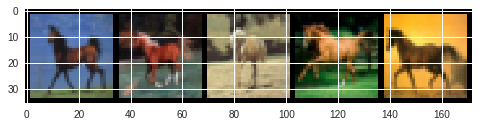

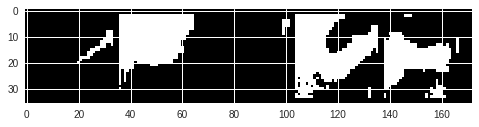

Validation set: IOU = 16.83%
Training Epoch 351 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 167.68347; IOU_batch = 87.25%
Validation set: IOU = 17.38%
Training Epoch 352 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 176.78984; IOU_batch = 84.48%
Validation set: IOU = 17.52%
Training Epoch 353 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 166.16374; IOU_batch = 83.03%
Validation set: IOU = 17.65%
Training Epoch 354 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 179.60907; IOU_batch = 83.50%
Validation set: IOU = 17.39%
Training Epoch 355 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 164.18253; IOU_batch = 83.93%
Validation set: IOU = 17.31%
Training Epoch 356 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 180.15607; IOU_batch = 81.58%
Validation set: IOU = 16.96%
Training Epoch 357 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 189.47511; IOU_batch = 79.35%
Validation set: IOU = 16.34%
Training Epoch 358 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 164.03

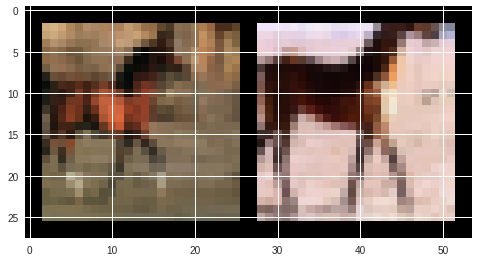

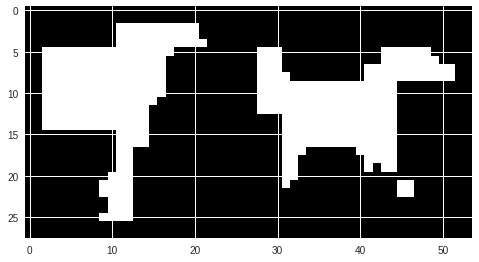

---------------------------------------



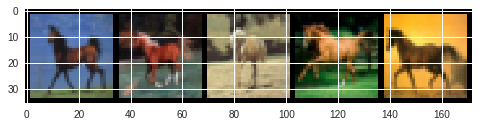

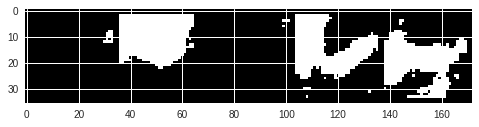

Validation set: IOU = 15.34%
Training Epoch 401 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 177.00331; IOU_batch = 80.75%
Validation set: IOU = 13.78%
Training Epoch 402 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 173.50374; IOU_batch = 79.09%
Validation set: IOU = 13.91%
Training Epoch 403 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 164.77020; IOU_batch = 85.05%
Validation set: IOU = 14.29%
Training Epoch 404 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 175.07004; IOU_batch = 81.37%
Validation set: IOU = 12.33%
Training Epoch 405 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 156.24767; IOU_batch = 81.75%
Validation set: IOU = 11.75%
Training Epoch 406 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 149.77467; IOU_batch = 84.89%
Validation set: IOU = 12.42%
Training Epoch 407 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 161.89680; IOU_batch = 83.63%
Validation set: IOU = 13.96%
Training Epoch 408 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 163.27

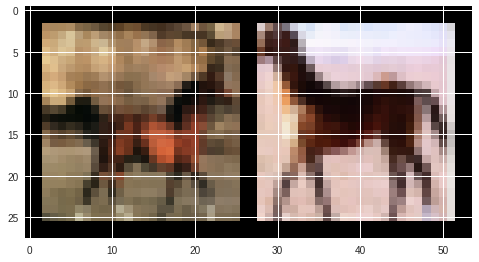

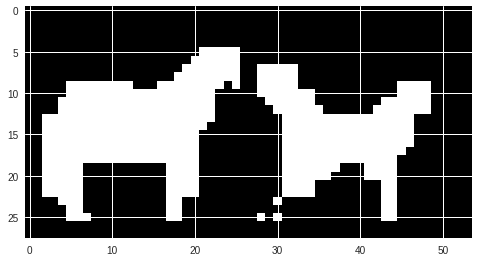

---------------------------------------



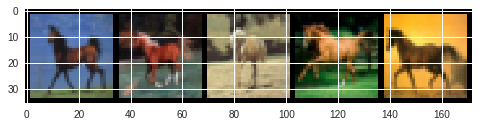

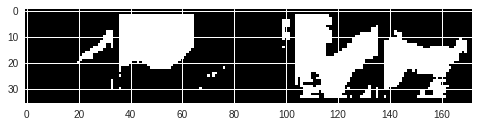

Validation set: IOU = 19.47%
Training Epoch 451 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 155.83684; IOU_batch = 82.51%
Validation set: IOU = 19.32%
Training Epoch 452 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 150.83372; IOU_batch = 84.79%
Validation set: IOU = 19.32%
Training Epoch 453 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 165.10239; IOU_batch = 82.75%
Validation set: IOU = 19.70%
Training Epoch 454 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 156.64247; IOU_batch = 83.81%
Validation set: IOU = 19.03%
Training Epoch 455 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 142.12914; IOU_batch = 86.14%
Validation set: IOU = 18.43%
Training Epoch 456 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 160.22139; IOU_batch = 80.56%
Validation set: IOU = 17.49%
Training Epoch 457 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 157.59738; IOU_batch = 85.14%
Validation set: IOU = 16.60%
Training Epoch 458 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 179.88

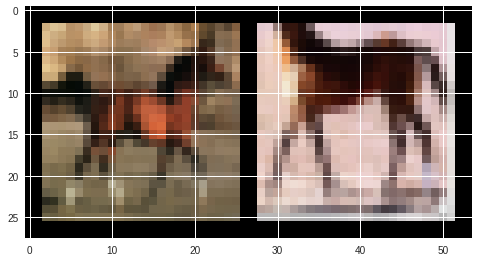

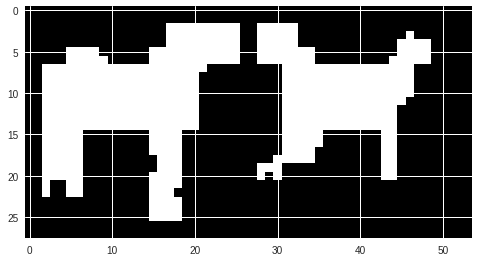

---------------------------------------



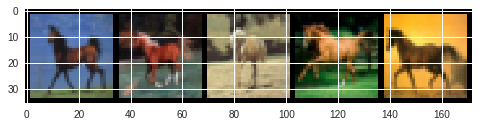

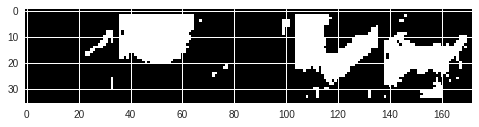

Validation set: IOU = 16.59%
Training Epoch 501 [2 / 2 (100%)]: Time per epoch: 0.04s; Avg_Loss = 155.15419; IOU_batch = 81.84%
Validation set: IOU = 16.73%
Training Epoch 502 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 152.98172; IOU_batch = 83.38%
Validation set: IOU = 17.29%
Training Epoch 503 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 147.32361; IOU_batch = 80.60%
Validation set: IOU = 17.84%
Training Epoch 504 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 165.61394; IOU_batch = 80.55%
Validation set: IOU = 18.93%
Training Epoch 505 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 144.69958; IOU_batch = 83.93%
Validation set: IOU = 19.70%
Training Epoch 506 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 167.20892; IOU_batch = 80.26%
Validation set: IOU = 20.05%
Training Epoch 507 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 164.57245; IOU_batch = 80.31%
Validation set: IOU = 19.93%
Training Epoch 508 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 138.84

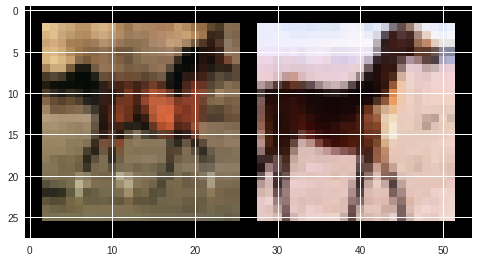

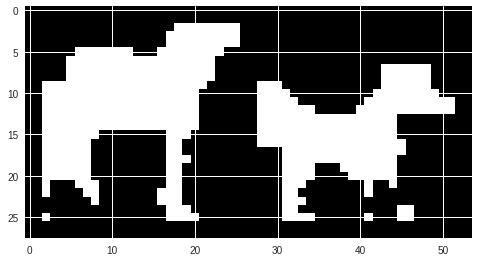

---------------------------------------



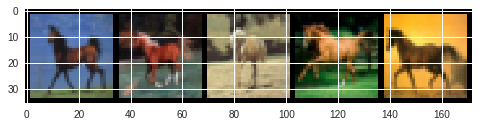

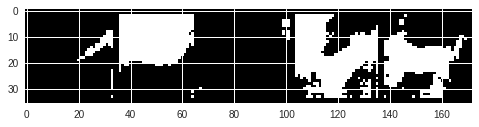

Validation set: IOU = 17.33%
Training Epoch 551 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 136.01320; IOU_batch = 84.82%
Validation set: IOU = 18.67%
Training Epoch 552 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 151.07899; IOU_batch = 82.04%
Validation set: IOU = 19.05%
Training Epoch 553 [2 / 2 (100%)]: Time per epoch: 0.03s; Avg_Loss = 135.79427; IOU_batch = 83.87%
Validation set: IOU = 18.85%
Training Epoch 554 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 147.07968; IOU_batch = 83.50%
Validation set: IOU = 18.11%
Training Epoch 555 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 148.76212; IOU_batch = 84.18%
Validation set: IOU = 17.73%
Training Epoch 556 [2 / 2 (100%)]: Time per epoch: 0.03s; Avg_Loss = 131.49843; IOU_batch = 84.03%
Validation set: IOU = 18.33%
Training Epoch 557 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 129.09091; IOU_batch = 86.58%
Validation set: IOU = 19.20%
Training Epoch 558 [2 / 2 (100%)]: Time per epoch: 0.03s; Avg_Loss = 144.99

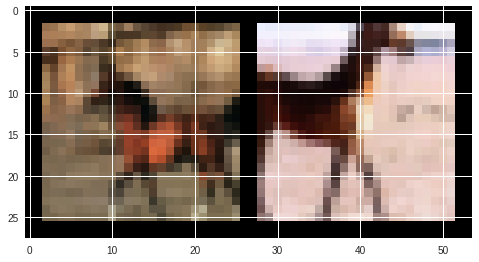

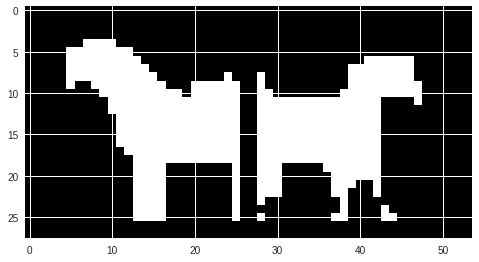

---------------------------------------



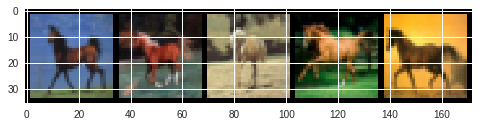

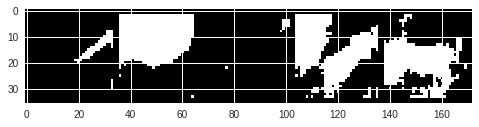

Validation set: IOU = 18.20%
Training Epoch 601 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 139.20004; IOU_batch = 85.17%
Validation set: IOU = 17.48%
Training Epoch 602 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 131.13475; IOU_batch = 84.89%
Validation set: IOU = 16.72%
Training Epoch 603 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 121.87395; IOU_batch = 87.37%
Validation set: IOU = 16.07%
Training Epoch 604 [2 / 2 (100%)]: Time per epoch: 0.03s; Avg_Loss = 136.60931; IOU_batch = 86.15%
Validation set: IOU = 16.38%
Training Epoch 605 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 127.68977; IOU_batch = 88.64%
Validation set: IOU = 16.63%
Training Epoch 606 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 131.88164; IOU_batch = 84.97%
Validation set: IOU = 16.65%
Training Epoch 607 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 119.23148; IOU_batch = 88.08%
Validation set: IOU = 16.85%
Training Epoch 608 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 129.54

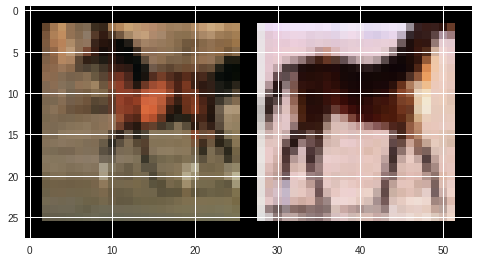

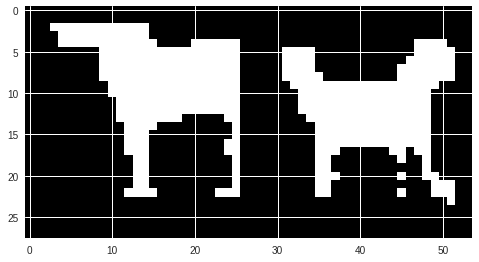

---------------------------------------



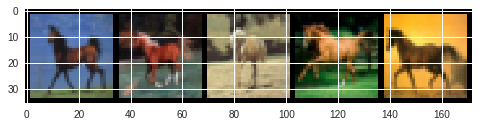

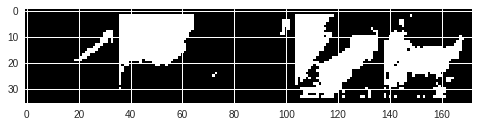

Validation set: IOU = 16.02%
Training Epoch 651 [2 / 2 (100%)]: Time per epoch: 0.03s; Avg_Loss = 113.76598; IOU_batch = 90.52%
Validation set: IOU = 16.82%
Training Epoch 652 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 140.74692; IOU_batch = 83.38%
Validation set: IOU = 17.06%
Training Epoch 653 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 127.64336; IOU_batch = 85.45%
Validation set: IOU = 17.26%
Training Epoch 654 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 120.49978; IOU_batch = 88.45%
Validation set: IOU = 17.09%
Training Epoch 655 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 120.95908; IOU_batch = 86.23%
Validation set: IOU = 17.23%
Training Epoch 656 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 121.08674; IOU_batch = 86.89%
Validation set: IOU = 17.27%
Training Epoch 657 [2 / 2 (100%)]: Time per epoch: 0.03s; Avg_Loss = 111.36057; IOU_batch = 88.71%
Validation set: IOU = 17.39%
Training Epoch 658 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 123.36

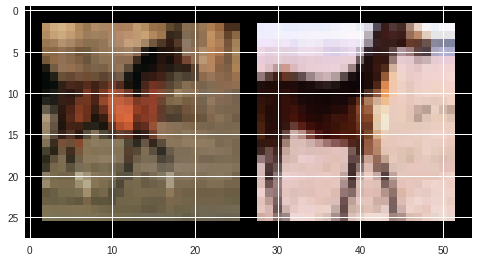

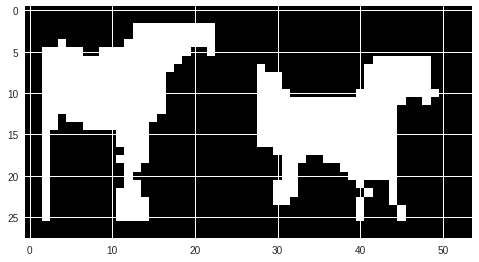

---------------------------------------



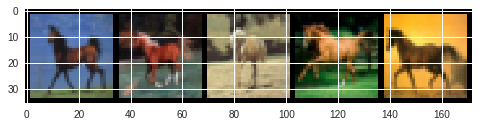

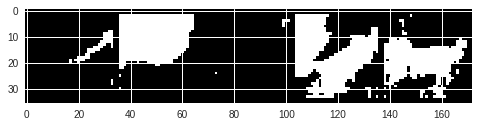

Validation set: IOU = 17.57%
Training Epoch 701 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 115.88383; IOU_batch = 88.48%
Validation set: IOU = 17.31%
Training Epoch 702 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 109.31012; IOU_batch = 90.27%
Validation set: IOU = 17.16%
Training Epoch 703 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 111.54449; IOU_batch = 88.94%
Validation set: IOU = 17.06%
Training Epoch 704 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 112.21343; IOU_batch = 90.44%
Validation set: IOU = 17.07%
Training Epoch 705 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 124.06860; IOU_batch = 86.02%
Validation set: IOU = 17.20%
Training Epoch 706 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 110.11327; IOU_batch = 87.97%
Validation set: IOU = 18.44%
Training Epoch 707 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 127.33934; IOU_batch = 87.21%
Validation set: IOU = 18.81%
Training Epoch 708 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 117.87

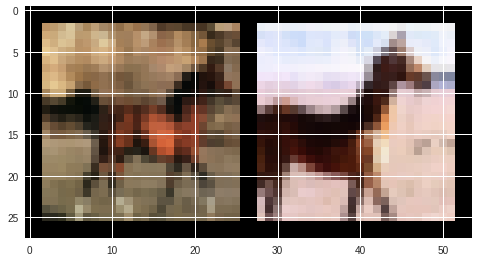

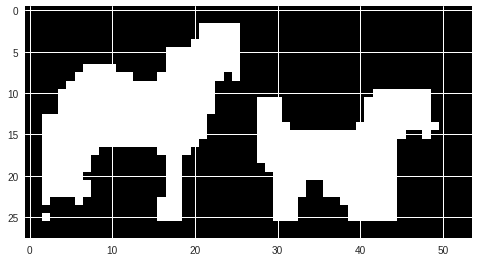

---------------------------------------



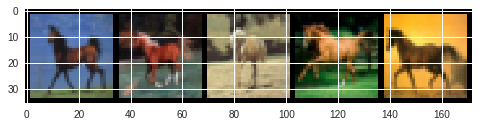

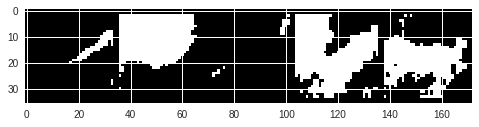

Validation set: IOU = 19.43%
Training Epoch 751 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 100.94104; IOU_batch = 90.37%
Validation set: IOU = 19.60%
Training Epoch 752 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 129.26981; IOU_batch = 86.96%
Validation set: IOU = 19.03%
Training Epoch 753 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 111.64339; IOU_batch = 87.14%
Validation set: IOU = 18.67%
Training Epoch 754 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 116.31906; IOU_batch = 88.14%
Validation set: IOU = 18.49%
Training Epoch 755 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 115.61324; IOU_batch = 87.71%
Validation set: IOU = 18.13%
Training Epoch 756 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 116.52029; IOU_batch = 87.13%
Validation set: IOU = 17.96%
Training Epoch 757 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 103.30239; IOU_batch = 90.49%
Validation set: IOU = 18.50%
Training Epoch 758 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 117.39

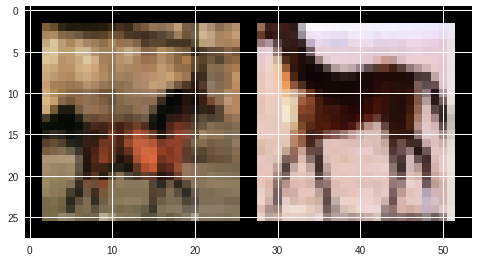

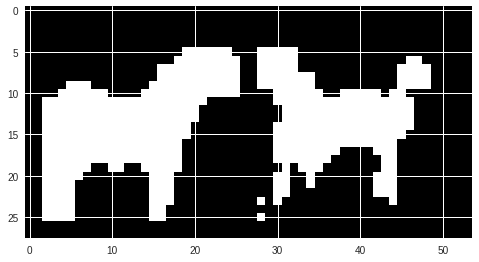

---------------------------------------



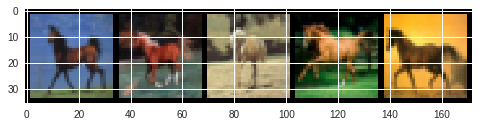

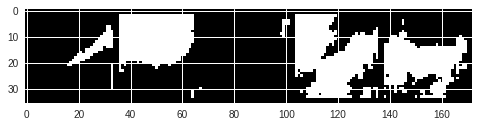

Validation set: IOU = 18.36%
Training Epoch 801 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 108.17303; IOU_batch = 90.31%
Validation set: IOU = 19.00%
Training Epoch 802 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 102.39149; IOU_batch = 88.85%
Validation set: IOU = 19.63%
Training Epoch 803 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 113.11141; IOU_batch = 87.14%
Validation set: IOU = 19.93%
Training Epoch 804 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 86.13339; IOU_batch = 92.07%
Validation set: IOU = 20.25%
Training Epoch 805 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 87.45726; IOU_batch = 90.29%
Validation set: IOU = 20.67%
Training Epoch 806 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 110.74155; IOU_batch = 89.78%
Validation set: IOU = 20.40%
Training Epoch 807 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 102.55335; IOU_batch = 88.24%
Validation set: IOU = 20.05%
Training Epoch 808 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 90.82113

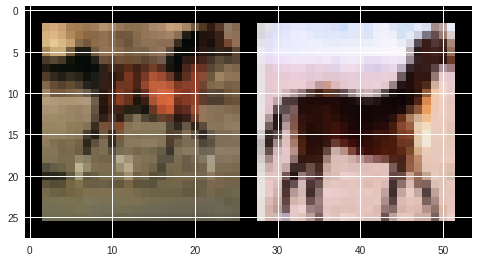

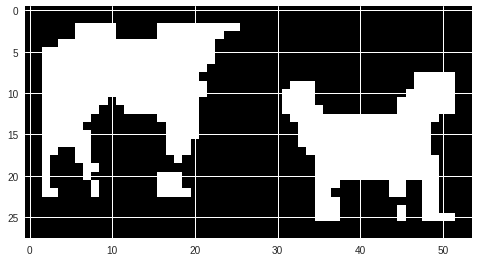

---------------------------------------



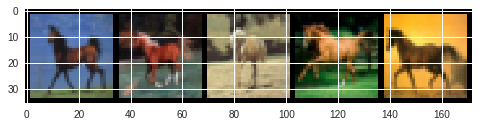

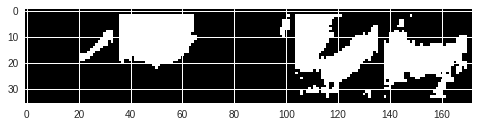

Validation set: IOU = 19.50%
Training Epoch 851 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 103.85271; IOU_batch = 87.69%
Validation set: IOU = 17.01%
Training Epoch 852 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 95.41277; IOU_batch = 89.51%
Validation set: IOU = 15.41%
Training Epoch 853 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 104.29756; IOU_batch = 88.02%
Validation set: IOU = 13.76%
Training Epoch 854 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 82.28694; IOU_batch = 92.03%
Validation set: IOU = 12.66%
Training Epoch 855 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 98.60925; IOU_batch = 89.92%
Validation set: IOU = 12.38%
Training Epoch 856 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 90.25147; IOU_batch = 90.94%
Validation set: IOU = 13.07%
Training Epoch 857 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 80.43736; IOU_batch = 93.40%
Validation set: IOU = 15.06%
Training Epoch 858 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 110.85928; 

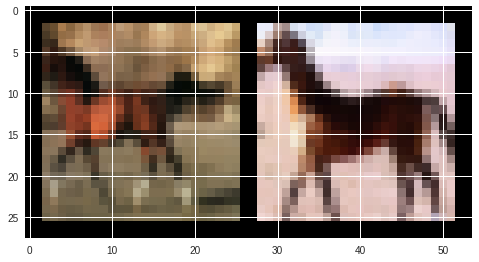

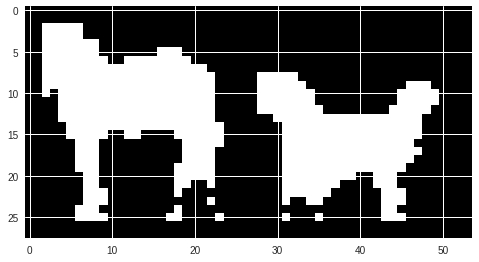

---------------------------------------



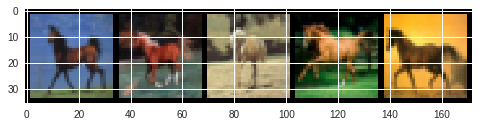

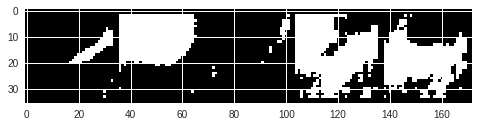

Validation set: IOU = 21.78%
Training Epoch 901 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 85.28812; IOU_batch = 93.36%
Validation set: IOU = 21.80%
Training Epoch 902 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 95.57201; IOU_batch = 90.08%
Validation set: IOU = 21.69%
Training Epoch 903 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 104.26295; IOU_batch = 89.45%
Validation set: IOU = 21.19%
Training Epoch 904 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 95.81303; IOU_batch = 89.31%
Validation set: IOU = 21.08%
Training Epoch 905 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 104.69781; IOU_batch = 89.09%
Validation set: IOU = 20.02%
Training Epoch 906 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 103.03912; IOU_batch = 85.94%
Validation set: IOU = 19.51%
Training Epoch 907 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 87.26184; IOU_batch = 90.61%
Validation set: IOU = 18.94%
Training Epoch 908 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 101.95409;

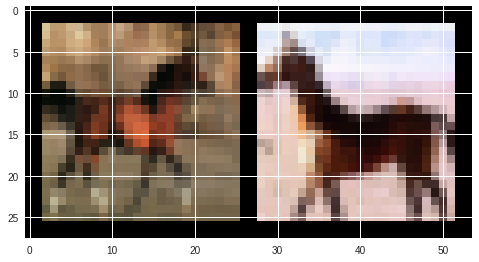

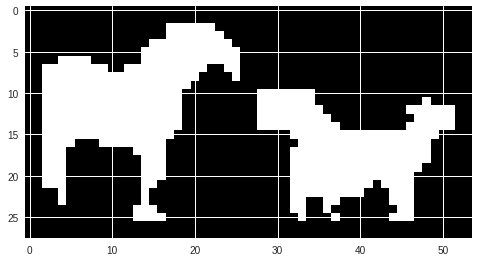

---------------------------------------



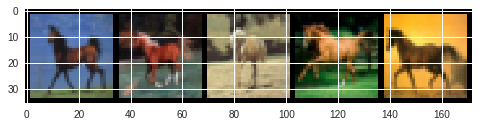

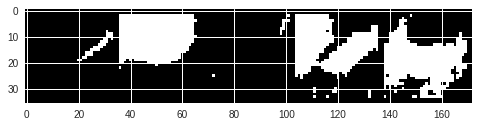

Validation set: IOU = 19.43%
Training Epoch 951 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 83.45172; IOU_batch = 92.91%
Validation set: IOU = 19.73%
Training Epoch 952 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 90.42168; IOU_batch = 88.54%
Validation set: IOU = 20.12%
Training Epoch 953 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 91.60281; IOU_batch = 91.19%
Validation set: IOU = 20.01%
Training Epoch 954 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 83.80495; IOU_batch = 92.99%
Validation set: IOU = 19.99%
Training Epoch 955 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 92.14553; IOU_batch = 89.04%
Validation set: IOU = 19.44%
Training Epoch 956 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 105.09860; IOU_batch = 87.79%
Validation set: IOU = 18.97%
Training Epoch 957 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 83.98328; IOU_batch = 93.80%
Validation set: IOU = 18.83%
Training Epoch 958 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 89.56883; IO

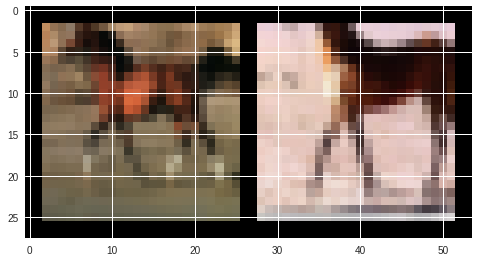

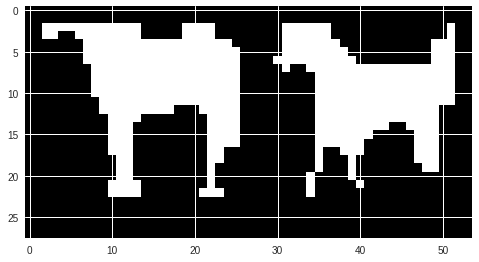

---------------------------------------



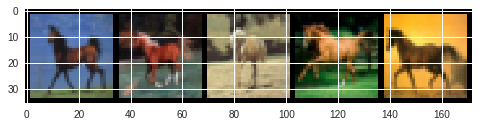

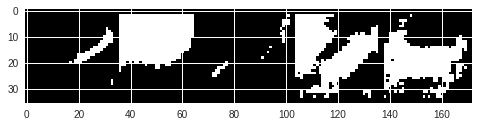

Validation set: IOU = 19.16%
Training Epoch 1001 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 81.75948; IOU_batch = 92.08%
Validation set: IOU = 19.36%
Training Epoch 1002 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 79.16753; IOU_batch = 92.27%
Validation set: IOU = 19.68%
Training Epoch 1003 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 88.60045; IOU_batch = 91.07%
Validation set: IOU = 19.53%
Training Epoch 1004 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 95.33895; IOU_batch = 89.62%
Validation set: IOU = 20.04%
Training Epoch 1005 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 67.43580; IOU_batch = 93.23%
Validation set: IOU = 20.75%
Training Epoch 1006 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 88.76694; IOU_batch = 90.09%
Validation set: IOU = 20.98%
Training Epoch 1007 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 84.31516; IOU_batch = 92.95%
Validation set: IOU = 21.33%
Training Epoch 1008 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 77.12

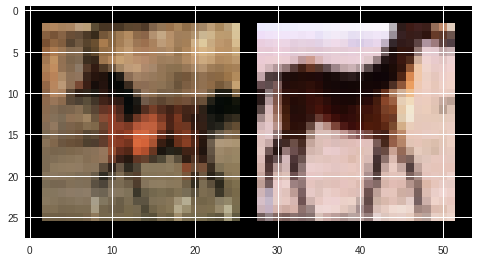

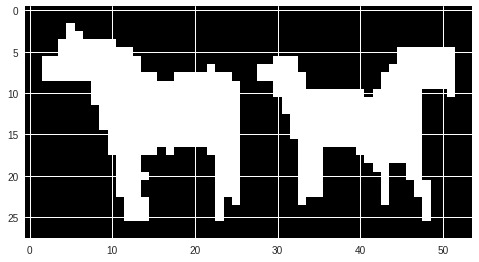

---------------------------------------



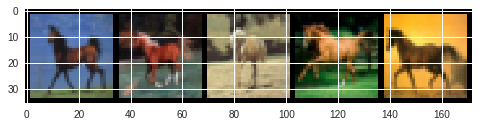

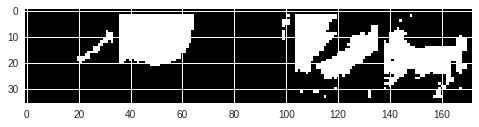

Validation set: IOU = 16.92%
Training Epoch 1051 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 80.66151; IOU_batch = 91.84%
Validation set: IOU = 17.69%
Training Epoch 1052 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 85.61824; IOU_batch = 91.99%
Validation set: IOU = 18.56%
Training Epoch 1053 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 94.11409; IOU_batch = 90.72%
Validation set: IOU = 18.71%
Training Epoch 1054 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 81.28183; IOU_batch = 90.87%
Validation set: IOU = 19.27%
Training Epoch 1055 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 84.48202; IOU_batch = 91.23%
Validation set: IOU = 19.26%
Training Epoch 1056 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 78.39458; IOU_batch = 92.85%
Validation set: IOU = 19.36%
Training Epoch 1057 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 80.04763; IOU_batch = 90.67%
Validation set: IOU = 19.38%
Training Epoch 1058 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 81.78

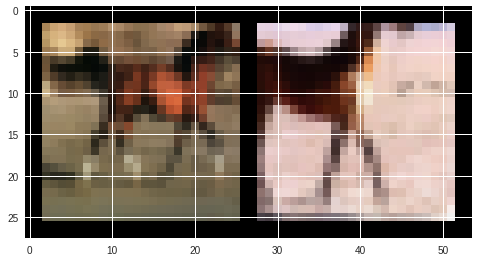

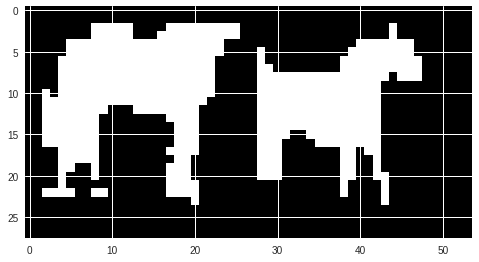

---------------------------------------



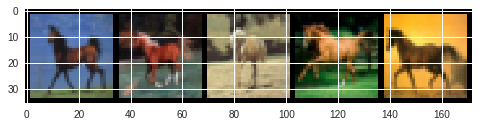

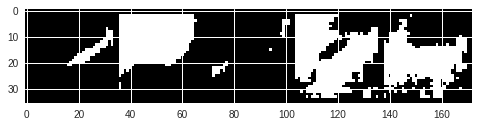

Validation set: IOU = 19.68%
Training Epoch 1101 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 79.85180; IOU_batch = 93.19%
Validation set: IOU = 19.86%
Training Epoch 1102 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 78.78617; IOU_batch = 90.89%
Validation set: IOU = 19.89%
Training Epoch 1103 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 78.34694; IOU_batch = 90.61%
Validation set: IOU = 19.56%
Training Epoch 1104 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 76.74045; IOU_batch = 93.36%
Validation set: IOU = 19.32%
Training Epoch 1105 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 70.40962; IOU_batch = 92.41%
Validation set: IOU = 18.69%
Training Epoch 1106 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 70.12569; IOU_batch = 93.61%
Validation set: IOU = 17.51%
Training Epoch 1107 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 80.12231; IOU_batch = 91.70%
Validation set: IOU = 16.96%
Training Epoch 1108 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 81.42

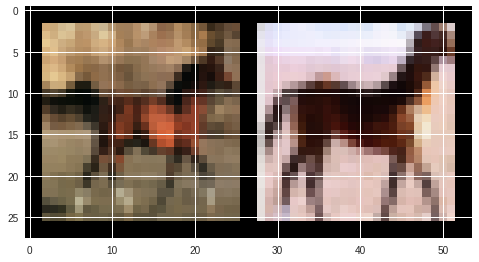

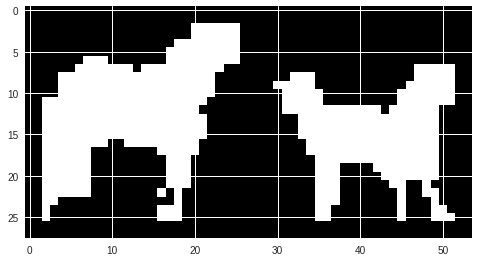

---------------------------------------



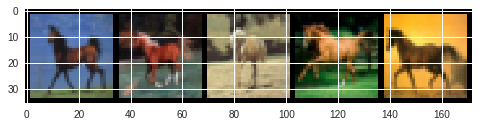

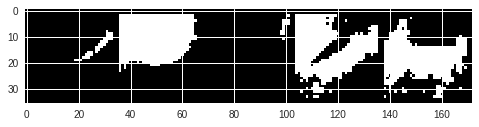

Validation set: IOU = 19.38%
Training Epoch 1151 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 74.54231; IOU_batch = 93.44%
Validation set: IOU = 18.85%
Training Epoch 1152 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 71.96254; IOU_batch = 92.70%
Validation set: IOU = 18.03%
Training Epoch 1153 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 81.99810; IOU_batch = 91.67%
Validation set: IOU = 17.35%
Training Epoch 1154 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 63.78186; IOU_batch = 96.03%
Validation set: IOU = 17.30%
Training Epoch 1155 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 85.16141; IOU_batch = 89.62%
Validation set: IOU = 17.45%
Training Epoch 1156 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 78.91835; IOU_batch = 93.97%
Validation set: IOU = 17.63%
Training Epoch 1157 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 80.08525; IOU_batch = 92.62%
Validation set: IOU = 17.71%
Training Epoch 1158 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 60.64

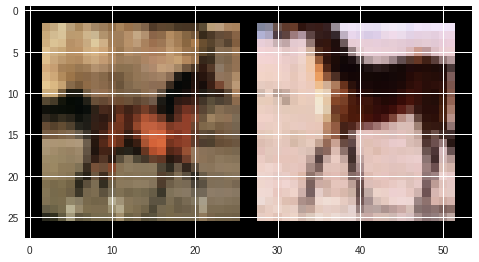

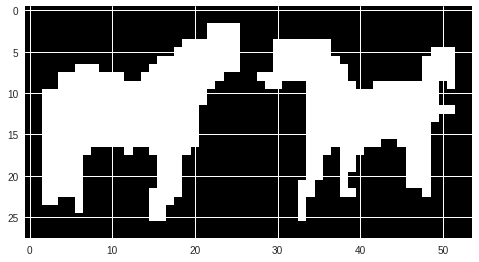

---------------------------------------



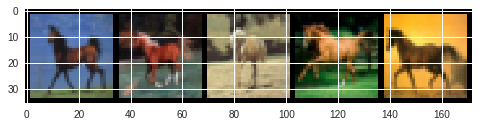

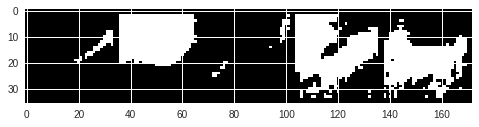

Validation set: IOU = 20.32%
Training Epoch 1201 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 74.05348; IOU_batch = 92.96%
Validation set: IOU = 19.85%
Training Epoch 1202 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 70.22501; IOU_batch = 94.03%
Validation set: IOU = 19.02%
Training Epoch 1203 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 71.46037; IOU_batch = 92.91%
Validation set: IOU = 18.86%
Training Epoch 1204 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 66.99965; IOU_batch = 93.23%
Validation set: IOU = 18.75%
Training Epoch 1205 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 75.10865; IOU_batch = 91.90%
Validation set: IOU = 18.65%
Training Epoch 1206 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 84.86503; IOU_batch = 89.37%
Validation set: IOU = 18.58%
Training Epoch 1207 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 70.25112; IOU_batch = 91.94%
Validation set: IOU = 18.84%
Training Epoch 1208 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 86.08

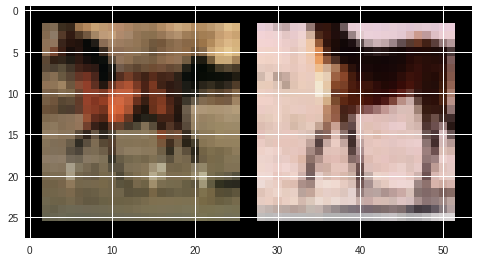

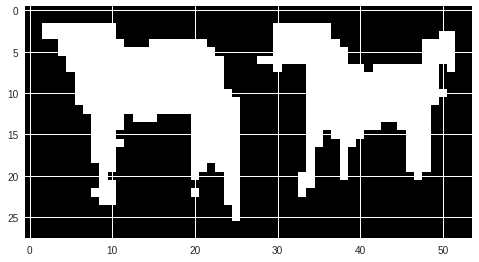

---------------------------------------



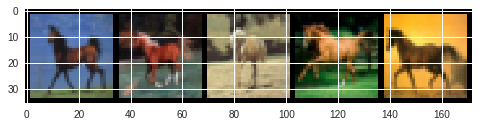

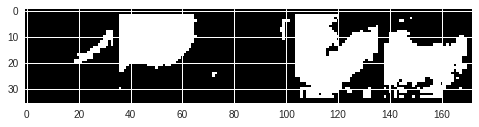

Validation set: IOU = 20.50%
Training Epoch 1251 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 68.03742; IOU_batch = 92.63%
Validation set: IOU = 20.77%
Training Epoch 1252 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 78.01026; IOU_batch = 91.54%
Validation set: IOU = 20.70%
Training Epoch 1253 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 65.73482; IOU_batch = 92.57%
Validation set: IOU = 20.62%
Training Epoch 1254 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 63.86605; IOU_batch = 92.80%
Validation set: IOU = 20.17%
Training Epoch 1255 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 73.80432; IOU_batch = 92.68%
Validation set: IOU = 19.47%
Training Epoch 1256 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 60.23264; IOU_batch = 94.52%
Validation set: IOU = 18.97%
Training Epoch 1257 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 71.46533; IOU_batch = 92.47%
Validation set: IOU = 18.08%
Training Epoch 1258 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 78.81

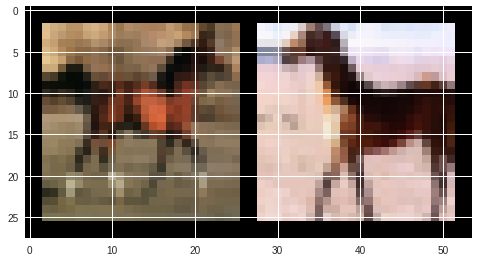

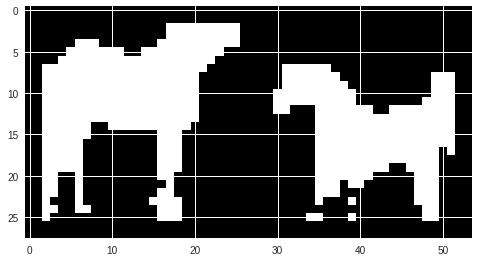

---------------------------------------



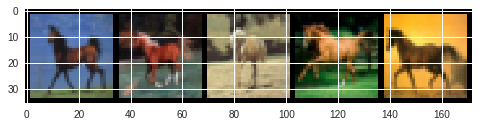

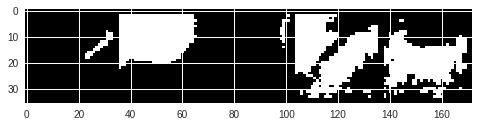

Validation set: IOU = 18.71%
Training Epoch 1301 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 68.49917; IOU_batch = 92.51%
Validation set: IOU = 18.31%
Training Epoch 1302 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 62.80806; IOU_batch = 93.20%
Validation set: IOU = 18.16%
Training Epoch 1303 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 69.52006; IOU_batch = 91.94%
Validation set: IOU = 18.83%
Training Epoch 1304 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 67.29993; IOU_batch = 93.30%
Validation set: IOU = 19.42%
Training Epoch 1305 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 57.44400; IOU_batch = 95.44%
Validation set: IOU = 19.99%
Training Epoch 1306 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 60.67698; IOU_batch = 92.46%
Validation set: IOU = 20.82%
Training Epoch 1307 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 61.21309; IOU_batch = 94.73%
Validation set: IOU = 21.38%
Training Epoch 1308 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 72.12

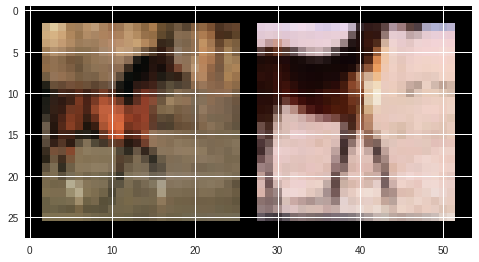

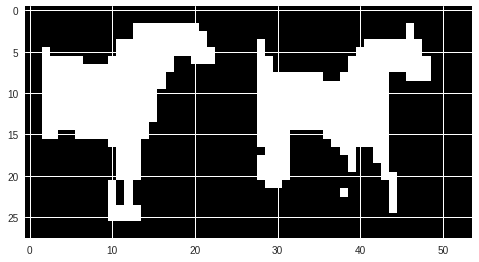

---------------------------------------



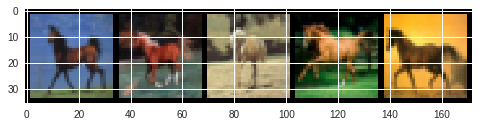

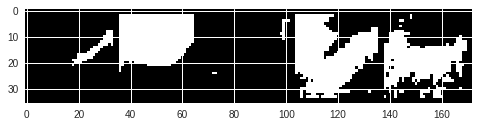

Validation set: IOU = 19.28%
Training Epoch 1351 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 50.97034; IOU_batch = 94.20%
Validation set: IOU = 19.70%
Training Epoch 1352 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 73.34804; IOU_batch = 92.97%
Validation set: IOU = 19.69%
Training Epoch 1353 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 69.49868; IOU_batch = 92.27%
Validation set: IOU = 19.74%
Training Epoch 1354 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 54.07877; IOU_batch = 94.84%
Validation set: IOU = 19.53%
Training Epoch 1355 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 67.59708; IOU_batch = 92.70%
Validation set: IOU = 19.41%
Training Epoch 1356 [2 / 2 (100%)]: Time per epoch: 0.03s; Avg_Loss = 59.32516; IOU_batch = 96.60%
Validation set: IOU = 19.51%
Training Epoch 1357 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 68.70276; IOU_batch = 92.62%
Validation set: IOU = 19.51%
Training Epoch 1358 [2 / 2 (100%)]: Time per epoch: 0.02s; Avg_Loss = 71.18

KeyboardInterrupt: ignored

In [0]:

# Fully convnet model
run_fcn_model(train_loader, valid_loader, dir_path, use_cuda, n_epochs=2000)